# <span style="font-size: 2.65em; color: purple">Classification of three car models + Deployment</span>

# Description

Необходимо создать, обучить нейронную сеть с точностью не менее 85% и упаковать её в архив для загрузки на демо-панель:
* создать нейронную сеть для распознавания марки автомобиля из 3х вариантов
* сохраните веса
* подготовить запуск модели "из коробки"
* подготовить архив с готовой нейронной сетью для загрузки в демо-панель

# Imports - Preliminary

In [1]:
from maat_machine import utils as mt_utils
from maat_machine import time as mt_time
from maat_machine import packages as mt_packages
from maat_machine import logging as mt_logging
from maat_machine import plots as mt_plt
from maat_machine import filesystem as mt_fs
from maat_machine import directory_tree as mt_fstree
from maat_machine import archive as mt_archive

from maat_machine import data_images as mt_dimg

from maat_machine.pprint import displayit, displayitwell, dict_to_html

2024-06-21 23:12:43.266962: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-21 23:12:43.297235: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 23:12:44.161964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/sorcerer/.pyenv/versions/3.11.9/envs/dl_python_3_11_9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteb

# Environment

In [2]:
ONLINE_ENVIRONMENT = False

In [3]:
mt_utils.display_environment_info()

2024-06-21 23:12:45.860597: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 23:12:45.971101: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 23:12:45.971142: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 23:12:45.972051: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Tasks

## Packages

In [4]:
mt_packages.install_packages(['gdown', 'Augmentor', 'mplcyberpunk', 'plotly'])

✔️ Installing 'pip'...

✔️ Installing 'gdown'...

✔️ Installing 'Augmentor'...

✔️ Installing 'mplcyberpunk'...

✔️ Installing 'plotly'...



## Utils

In [5]:
mt_logging.init_logging()

import matplotlib.pyplot as plt
import mplcyberpunk
mt_plt.set_theme_matplotlib('cyberpunk')

# Imports - Main

In [6]:
import time
import random
import pathlib as paths
import shutil

import gdown

import cv2 as cv

import numpy as np
import pandas as pd

from sklearn import base as sk_base
from sklearn import model_selection as sk_modsel
from sklearn import pipeline as sk_pipe
from sklearn import preprocessing as sk_prep
from sklearn import metrics as sk_metr
from sklearn import datasets as sk_data
from sklearn import cluster as sk_cluster
from sklearn import utils as sk_utils
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning

import tensorflow as tf
from tensorflow import keras as ktf
from keras import models as mktf
from keras import layers as lktf
from keras import optimizers as oktf
from keras import preprocessing as ppktf
from keras import utils as uktf
from keras import losses as lsktf

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from IPython.display import display

In [7]:
mt_plt.set_theme_matplotlib('cyberpunk')

# Data Loading

In [8]:
DATA_ROOT_DIRECTORY = paths.Path('./data')
# DATA_ROOT_DIRECTORY = paths.Path('/kaggle/working')
mt_fs.make_directory(DATA_ROOT_DIRECTORY, path_comment='Root path directory')

In [9]:
DIRECTORY_OBJECT_NAMES = ['object-archives', 'object-original', 'object-prepared', 'object-train', 'object-augmented', 'object-test']
TEMPORARY_OBJECT_NAMES = ['object-prepared', 'object-train', 'object-augmented', 'object-test']
OBJECT_DIRECTORIES = {name: paths.PurePath(name) for name in DIRECTORY_OBJECT_NAMES}

object_directory_full_paths = mt_fs.make_directories_in_parent(
    list(OBJECT_DIRECTORIES.values()),
    DATA_ROOT_DIRECTORY,
    path_comment='Object data directory'
)

assert all(path.name in OBJECT_DIRECTORIES for path in object_directory_full_paths)
for path in object_directory_full_paths:
    OBJECT_DIRECTORIES[path.name] = path

displayitwell(dict_to_html(OBJECT_DIRECTORIES), color='navy', font_weight='bold', inline=False)

## Temporary object directories clean up

In [10]:
TEMPORARY_OBJECT_DIRECTORIES = {name: OBJECT_DIRECTORIES[name] for name in TEMPORARY_OBJECT_NAMES}
displayitwell(dict_to_html(TEMPORARY_OBJECT_DIRECTORIES), color='darkorange', font_weight='bold', inline=False)

In [11]:
for directory in TEMPORARY_OBJECT_DIRECTORIES.values():
    for item in directory.glob('*'):
        if item.is_file():
            item.unlink()  # For files
        else:
            shutil.rmtree(item)  # For directories

## Data download and unpack

In [12]:
DOWNLOAD_DATA = True
UNPACK_DATA = True
DATA_URL = 'https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip'
_, _, file_extension = mt_fs.extract_file_info_from_url(DATA_URL)
assert file_extension == '.zip'
DATA_TARGET_FILE = OBJECT_DIRECTORIES['object-archives'].joinpath(paths.PurePath(f"data{file_extension}"))

if DOWNLOAD_DATA:
    gdown.download(
        DATA_URL,
        output=str(DATA_TARGET_FILE),
        quiet=False,
        user_agent='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36 Edge/16.16299'
    )
    assert DATA_TARGET_FILE.is_file()

if UNPACK_DATA:
    assert DATA_TARGET_FILE.is_file()
    mt_archive.unzip_to_directory(DATA_TARGET_FILE, OBJECT_DIRECTORIES['object-original'])

mt_fs.list_directory(OBJECT_DIRECTORIES['object-original'])

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip
To: /home/sorcerer/Projects/Education/ML/UAI/04-Deployment/project-car-classification/data/object-archives/data.zip
100%|██████████| 119M/119M [00:10<00:00, 11.5MB/s] 


['Ferrari', 'Mercedes', 'Renault']

## Data samples

In [13]:
# Определение списка имен классов
CLASS_LIST = mt_fs.list_directory(OBJECT_DIRECTORIES['object-original'])

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f"Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}")

Количество классов: 3, метки классов: ['Ferrari', 'Mercedes', 'Renault']


In [14]:
mt_fstree.display_tree(OBJECT_DIRECTORIES['object-original'], max_files=7, max_depth=2)

object-original/
├── Ferrari/
│   ├── car_Ferrari__0.png
│   ├── car_Ferrari__1.png
│   ├── car_Ferrari__10.png
│   ├── car_Ferrari__100.png
│   ├── car_Ferrari__1000.png
│   ├── car_Ferrari__1002.png
│   └── car_Ferrari__1003.png
├── Mercedes/
│   ├── car__0.png
│   ├── car__1.png
│   ├── car__10.png
│   ├── car__100.png
│   ├── car__1000.png
│   ├── car__1001.png
│   └── car__1002.png
└── Renault/
    ├── car__0.png
    ├── car__1.png
    ├── car__10.png
    ├── car__100.png
    ├── car__1001.png
    ├── car__1002.png
    └── car__1003.png


In [15]:
CLASS_FILE_REPOSITORY = {class_directory.name: mt_fs.list_directory(class_directory, list_paths=True) for class_directory in mt_fs.list_directory(OBJECT_DIRECTORIES['object-original'], list_paths=True)}
displayitwell(f"CLASS_FILE_REPOSITORY object counts: {[(class_name + ' -> ' + str(len(class_object_list)) + ' of objects') for class_name, class_object_list in CLASS_FILE_REPOSITORY.items()]}", font_weight='bold')
for class_name, class_object_list in CLASS_FILE_REPOSITORY.items():
    displayitwell(f"<strong>Class \"{class_name}\":</strong> {class_object_list[:7]}")

In [16]:
assert CLASS_COUNT == len(CLASS_FILE_REPOSITORY)

time.sleep(0.5)

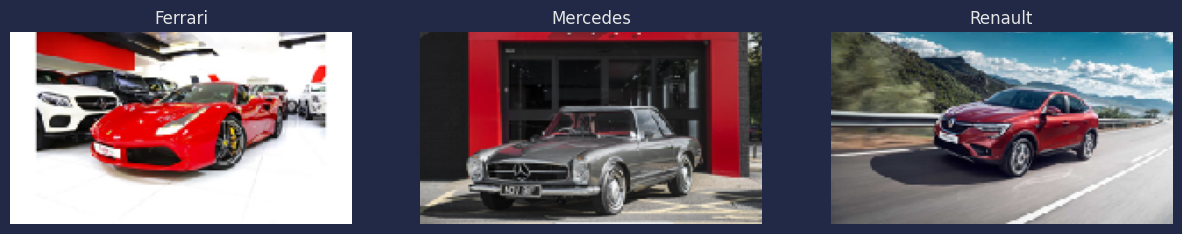

In [17]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(15, 5))

# Для всех номеров классов:
for i, item in enumerate(CLASS_FILE_REPOSITORY.items()):
    class_name, class_object_list = item
    # Выбор случайного фото из i-го класса
    random_image_path = random.choice(class_object_list)

    # Отображение фотографии
    image = cv.imread(str(random_image_path))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # Переводим изображение в формат RGB
    axs[i].set_title(class_name)
    axs[i].imshow(image)
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

time.sleep(0.5)

In [18]:
DATA_FRAMES = {
    class_name: pd.DataFrame({'file_path': class_object_list, 'label': [class_name] * len(class_object_list)}) \
        for class_name, class_object_list in CLASS_FILE_REPOSITORY.items()
}
DATA_FRAME = pd.concat(DATA_FRAMES, ignore_index=True)
CLASS_SIZES = dict(DATA_FRAME['label'].value_counts(sort=False))
CLASS_SIZES_ITEMS = list(enumerate(CLASS_SIZES.items()))
CLASS_SIZE_LIST = list(CLASS_SIZES.values())

displayitwell('<hr>')
for class_name, df in DATA_FRAMES.items():
    displayitwell(f"Класс \"{class_name}\"", font_size='14px', font_style='italic', font_weight='bold')
    display(df.head(5))
    displayitwell('<hr>')

displayitwell('<hr>')
displayitwell('Общая таблица', color='purple', font_size='14px', font_style='italic', font_weight='bold', text_decoration='black underline 2px')
displayitwell('▼ Начало таблицы', color='brown', font_size='12px',font_weight='bold')
display(DATA_FRAME.head(5))

class_shift = 0
for i, item in CLASS_SIZES_ITEMS[:-1]:
    if i >= len(CLASS_SIZES_ITEMS) - 1:
        break
    class_name, class_size = item
    _, next_item = CLASS_SIZES_ITEMS[i+1]
    next_class_name, next_class_size = next_item
    displayitwell(
        f"⬍ Середина таблицы для классов \"{class_name}\"({class_size}) и \"{next_class_name}\"({next_class_size}):",
        color='brown', font_size='12px', font_weight='bold'
    )
    indices_start = class_size - 4
    indices_end = class_size + 3
    display(DATA_FRAME.loc[(class_shift + indices_start):(class_shift + indices_end)])
    class_shift += class_size

displayitwell('▲ Конец таблицы', color='brown', font_size='12px', font_weight='bold')
display(DATA_FRAME.tail(5))
displayitwell('💎 Случайная выборка', color='navy', font_size='12px', font_weight='bold')
display(DATA_FRAME.sample(9))
displayitwell('<hr>')
displayitwell('<hr>')

displayitwell(f"Размеры классов: {dict(DATA_FRAME['label'].value_counts())}", font_size='14px', font_weight='bold', text_decoration='magenta solid underline 4px')
displayitwell(f"Общий размер базы для обучения: {len(DATA_FRAME)}", font_size='14px', font_weight='bold', text_decoration='magenta solid underline 4px')

,file_path,label
0,data/object-original/Ferrari/car_Ferrari__0.png,Ferrari
1,data/object-original/Ferrari/car_Ferrari__1.png,Ferrari
2,data/object-original/Ferrari/car_Ferrari__10.png,Ferrari
3,data/object-original/Ferrari/car_Ferrari__100.png,Ferrari
4,data/object-original/Ferrari/car_Ferrari__1000...,Ferrari


,file_path,label
0,data/object-original/Mercedes/car__0.png,Mercedes
1,data/object-original/Mercedes/car__1.png,Mercedes
2,data/object-original/Mercedes/car__10.png,Mercedes
3,data/object-original/Mercedes/car__100.png,Mercedes
4,data/object-original/Mercedes/car__1000.png,Mercedes


,file_path,label
0,data/object-original/Renault/car__0.png,Renault
1,data/object-original/Renault/car__1.png,Renault
2,data/object-original/Renault/car__10.png,Renault
3,data/object-original/Renault/car__100.png,Renault
4,data/object-original/Renault/car__1001.png,Renault


,file_path,label
0,data/object-original/Ferrari/car_Ferrari__0.png,Ferrari
1,data/object-original/Ferrari/car_Ferrari__1.png,Ferrari
2,data/object-original/Ferrari/car_Ferrari__10.png,Ferrari
3,data/object-original/Ferrari/car_Ferrari__100.png,Ferrari
4,data/object-original/Ferrari/car_Ferrari__1000...,Ferrari


,file_path,label
1084,data/object-original/Ferrari/car_Ferrari__996.png,Ferrari
1085,data/object-original/Ferrari/car_Ferrari__997.png,Ferrari
1086,data/object-original/Ferrari/car_Ferrari__998.png,Ferrari
1087,data/object-original/Ferrari/car_Ferrari__999.png,Ferrari
1088,data/object-original/Mercedes/car__0.png,Mercedes
1089,data/object-original/Mercedes/car__1.png,Mercedes
1090,data/object-original/Mercedes/car__10.png,Mercedes
1091,data/object-original/Mercedes/car__100.png,Mercedes


,file_path,label
2245,data/object-original/Mercedes/car__995.png,Mercedes
2246,data/object-original/Mercedes/car__996.png,Mercedes
2247,data/object-original/Mercedes/car__998.png,Mercedes
2248,data/object-original/Mercedes/car__999.png,Mercedes
2249,data/object-original/Renault/car__0.png,Renault
2250,data/object-original/Renault/car__1.png,Renault
2251,data/object-original/Renault/car__10.png,Renault
2252,data/object-original/Renault/car__100.png,Renault


,file_path,label
3422,data/object-original/Renault/car__995.png,Renault
3423,data/object-original/Renault/car__996.png,Renault
3424,data/object-original/Renault/car__997.png,Renault
3425,data/object-original/Renault/car__998.png,Renault
3426,data/object-original/Renault/car__999.png,Renault


,file_path,label
2262,data/object-original/Renault/car__1010.png,Renault
1707,data/object-original/Mercedes/car__447.png,Mercedes
1954,data/object-original/Mercedes/car__693.png,Mercedes
2436,data/object-original/Renault/car__1194.png,Renault
310,data/object-original/Ferrari/car_Ferrari__17.png,Ferrari
3415,data/object-original/Renault/car__988.png,Renault
2073,data/object-original/Mercedes/car__815.png,Mercedes
2410,data/object-original/Renault/car__1162.png,Renault
2711,data/object-original/Renault/car__243.png,Renault


# Data Preparation

In [19]:
min_width, max_width, min_height, max_height, avg_width, avg_height, channel_counts, recommended_width, recommended_height = \
    mt_dimg.calculate_image_statistics(DATA_FRAME['file_path'].to_list(), recommend_by='height')
displayitwell(f"Минимальные размеры картинок: {min_width} × {min_height}", font_weight='bold')
displayitwell(f"Средние размеры картинок: {avg_width:.1f} × {avg_height:.1f}", font_weight='bold')
displayitwell(f"Максимальные размеры картинок: {max_width} × {max_height}", font_weight='bold')
displayitwell(f"Числа каналов картинок: {set(channel_counts)}", font_weight='bold')
displayitwell(f"Рекомендуемый размер для подготовки набора картинок: {recommended_width} × {recommended_height}", color='purple', font_weight='bold')

## Image Resizing

In [20]:
from tqdm.auto import tqdm


DATASET = DATA_FRAME.copy(deep=True)

IMAGE_DIVISOR = 1

image_paths = DATA_FRAME['file_path']
target_fixed_height = int(avg_height) // IMAGE_DIVISOR
target_fixed_width = int(avg_width) // IMAGE_DIVISOR
target_channels = 3

pbar = tqdm(desc="Resizing images", total=len(image_paths), unit='file')
generator = mt_dimg.ImageResizingGenerator(
    image_paths, target_fixed_height, target_fixed_width, target_channels,
    OBJECT_DIRECTORIES['object-prepared'],
    pbar
)

with pbar:
    for idx, new_image_path in generator.generate_images():
        time.sleep(0.005)
        DATASET.loc[idx, 'file_path'] = new_image_path

Resized 🖼-#3426 (107, 192, 3)➡(107, 192, 3)🖬➡"data/object-prepared/image_3426.jpg": 100%|██████████| 3427/3427 [00:25<00:00, 134.84file/s]


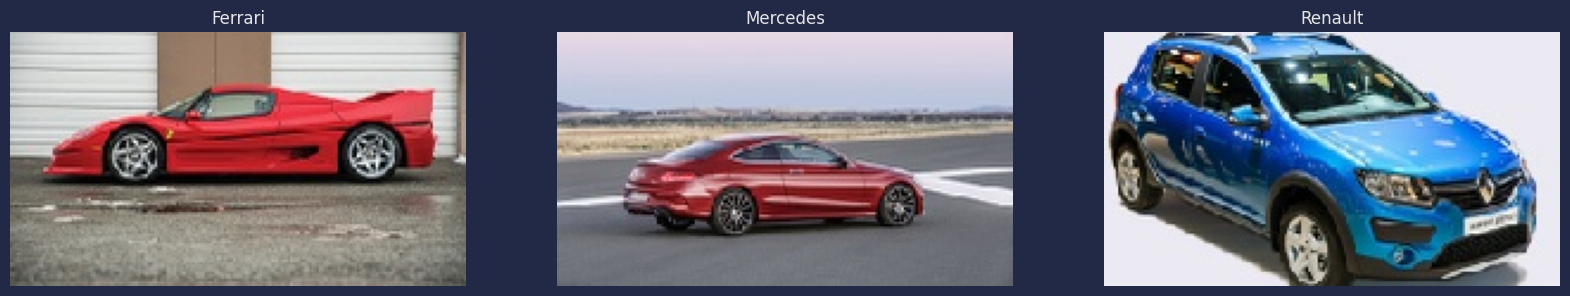

In [21]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(20, 20))

# Для всех номеров классов:
for i, item in enumerate(CLASS_LIST):
    class_name = item
    # Выбор случайного фото из i-го класса
    random_image_path = random.choice(DATASET[DATASET['label'] == class_name]['file_path'].to_list())

    # Отображение фотографии
    image = cv.imread(str(random_image_path))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # Переводим изображение в формат RGB
    axs[i].set_title(class_name)
    axs[i].imshow(image)
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

## Samples of Images

In [22]:
assert target_channels == 3

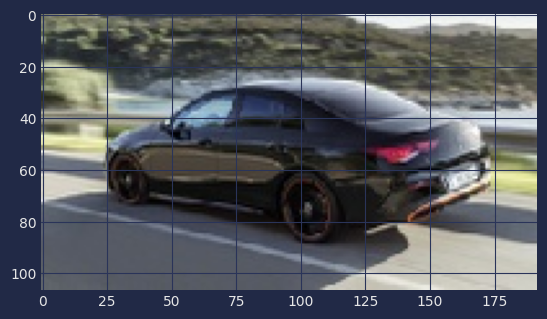

In [23]:
plt.imshow(mt_dimg.dataset_load_image(DATASET['file_path'].sample(1).iloc[0], target_channels))

In [24]:
DATASET.rename(columns={"label": "label_original"}, inplace=True)
DATASET.sample(9)

,file_path,label_original
2580,data/object-prepared/image_2580.jpg,Renault
558,data/object-prepared/image_558.jpg,Ferrari
543,data/object-prepared/image_543.jpg,Ferrari
3312,data/object-prepared/image_3312.jpg,Renault
2603,data/object-prepared/image_2603.jpg,Renault
160,data/object-prepared/image_160.jpg,Ferrari
2564,data/object-prepared/image_2564.jpg,Renault
71,data/object-prepared/image_71.jpg,Ferrari
392,data/object-prepared/image_392.jpg,Ferrari


In [25]:
DATASET.columns

Index(['file_path', 'label_original'], dtype='object')

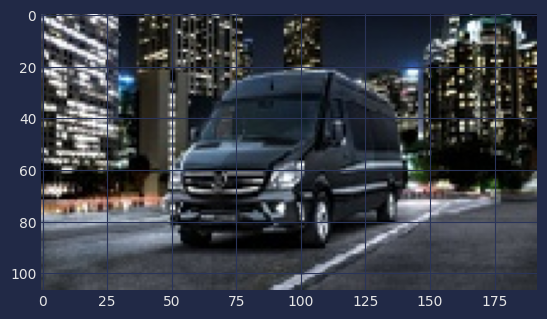

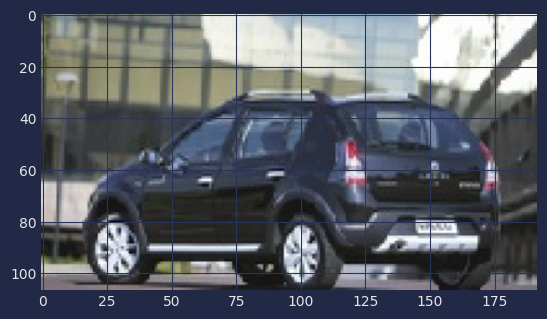

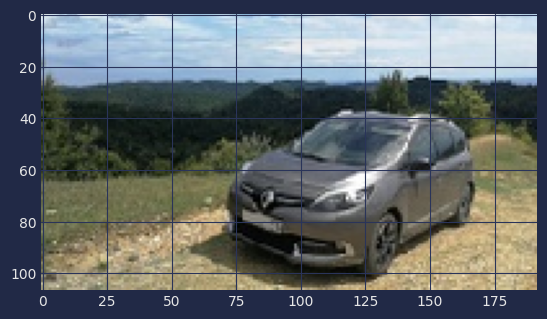

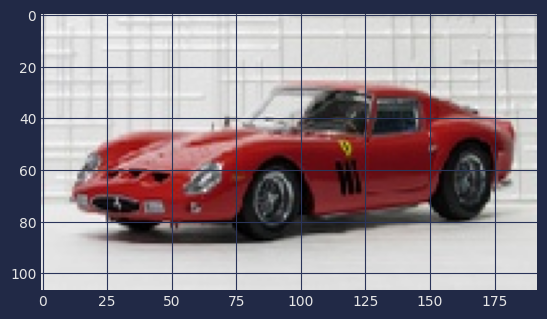

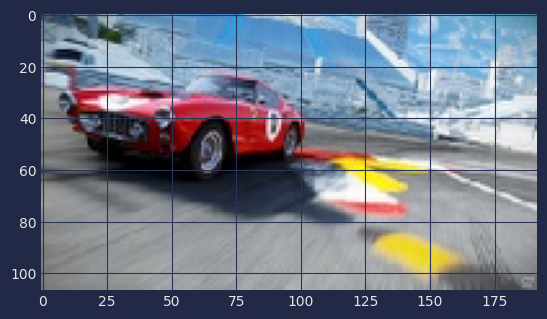

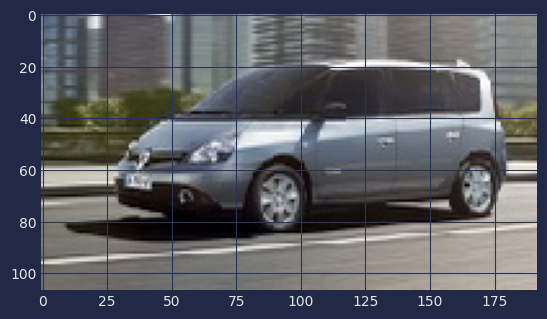

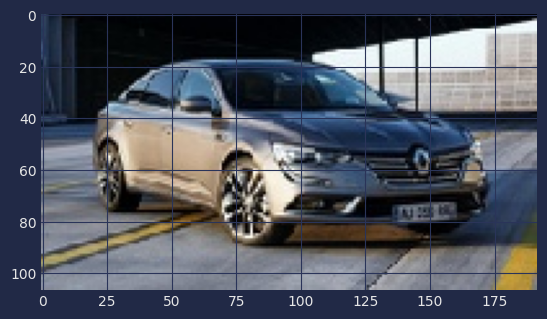

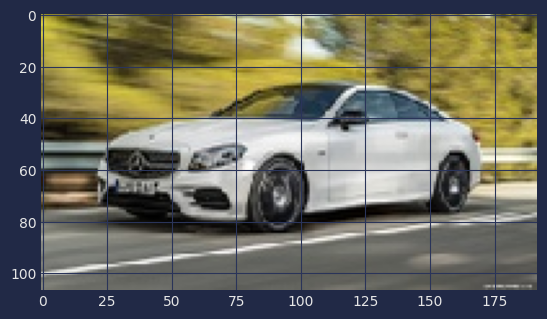

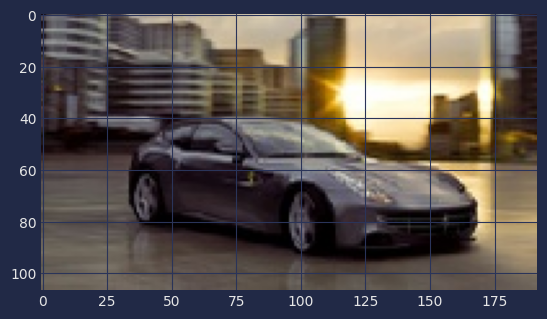

In [26]:
for index, row in DATASET.sample(9)[['label_original', 'file_path']].iterrows():
    displayitwell(f"CLASS = {row['label_original']}", font_weight='bold')
    plt.imshow(mt_dimg.dataset_load_image(row['file_path'], target_channels))
    plt.show()
    time.sleep(0.1)
    displayitwell(f'<hr>')

In [27]:
LABEL_ENCODER = sk_prep.OneHotEncoder(dtype=int)
LABEL_ENCODER.fit(DATASET['label_original'].values.reshape(-1, 1))

OneHotEncoder(dtype=<class 'int'>)

In [28]:
LABEL_ENCODER.get_feature_names_out()

array(['x0_Ferrari', 'x0_Mercedes', 'x0_Renault'], dtype=object)

## Train and Test Samples

In [29]:
if 'id' not in DATASET.columns:
    DATASET.insert(0, 'id', range(len(DATASET)))

In [30]:
TEST_SIZE = 0.1

TRAIN_DATASET, TEST_DATASET = sk_modsel.train_test_split(
    DATASET,
    test_size=TEST_SIZE,
    stratify=DATASET['label_original'],
    shuffle=True,
    random_state=42
)

In [31]:
TRAIN_DATASET.sample(5)

,id,file_path,label_original
273,273,data/object-prepared/image_273.jpg,Ferrari
319,319,data/object-prepared/image_319.jpg,Ferrari
3039,3039,data/object-prepared/image_3039.jpg,Renault
2468,2468,data/object-prepared/image_2468.jpg,Renault
223,223,data/object-prepared/image_223.jpg,Ferrari


In [32]:
TRAIN_DATASET['label_original'].value_counts(normalize=True).round(2)

label_original
Renault     0.34
Mercedes    0.34
Ferrari     0.32
Name: proportion, dtype: float64

In [33]:
LABELS_ORIGINAL = DATASET['label_original'].unique()
CLASSES_ENCODED = dict(zip(
    LABELS_ORIGINAL, [tuple(label) for label in LABEL_ENCODER.transform(LABELS_ORIGINAL.reshape(-1, 1)).toarray()]
))
display(CLASSES_ENCODED)
LABELS_ENCODED = {v: k for k, v in CLASSES_ENCODED.items()}
display(LABELS_ENCODED)

{'Ferrari': (1, 0, 0), 'Mercedes': (0, 1, 0), 'Renault': (0, 0, 1)}

{(1, 0, 0): 'Ferrari', (0, 1, 0): 'Mercedes', (0, 0, 1): 'Renault'}

In [34]:
for it in TRAIN_DATASET['label_original'].unique():
    print(it)

Renault
Ferrari
Mercedes


In [35]:
target_dirs = [
    (TRAIN_DATASET, OBJECT_DIRECTORIES['object-train']),
    (TEST_DATASET, OBJECT_DIRECTORIES['object-test'])
]

for dataset, destination_dir in target_dirs:
    for label_original in dataset['label_original'].unique():
        label_dir = destination_dir / label_original
        label_dir.mkdir(parents=True, exist_ok=True)

for dataset, destination_dir in target_dirs:
    for index, row in dataset.iterrows():
        label_original = row['label_original']
        object_file = row['file_path']
        destination_file = destination_dir / label_original / f"{object_file.stem}_L{label_original}{object_file.suffix}"
        shutil.copy(object_file, destination_file)

## Augmentation

In [36]:
TRAIN_AUGMENTED_OBJECT_DIRECTORIES = {
    OBJECT_DIRECTORIES['object-train'] / label_original: \
        {
            'directory': OBJECT_DIRECTORIES['object-augmented'] / label_original,
            'sample_size': len(TRAIN_DATASET['label_original'][TRAIN_DATASET['label_original'] == label_original])
        } \
        for label_original in TRAIN_DATASET['label_original'].unique()
}
TRAIN_AUGMENTED_OBJECT_DIRECTORIES

{PosixPath('data/object-train/Renault'): {'directory': PosixPath('data/object-augmented/Renault'),
  'sample_size': 1060},
 PosixPath('data/object-train/Ferrari'): {'directory': PosixPath('data/object-augmented/Ferrari'),
  'sample_size': 979},
 PosixPath('data/object-train/Mercedes'): {'directory': PosixPath('data/object-augmented/Mercedes'),
  'sample_size': 1045}}

In [37]:
AUGMENTED_CLASS_SIZE = np.max([augmented_data['sample_size'] for _, augmented_data in TRAIN_AUGMENTED_OBJECT_DIRECTORIES.items()])
AUGMENTED_CLASS_SIZE

1060

In [38]:
import Augmentor

SAMPLE_SIZE_MULTIPLIER = 4

for train_directory, augmented_data in TRAIN_AUGMENTED_OBJECT_DIRECTORIES.items():
    augmented_directory = augmented_data['directory']
    augmented_directory.mkdir(parents=True, exist_ok=True)

    sample_size = AUGMENTED_CLASS_SIZE

    output_directory_path_prefix = '../../../' if ONLINE_ENVIRONMENT else '../../../'

    # Pipeline аугментации.
    p = Augmentor.Pipeline(
        source_directory=str(train_directory),
        output_directory=output_directory_path_prefix + str(augmented_directory)
    )

    # Манипулируем фотографиями.
    p.rotate_without_crop(
        probability=0.5,
        max_left_rotation=8,
        max_right_rotation=8,
        expand=False
    )
    p.flip_left_right(
        probability=0.7
    )
    p.zoom(
        probability=0.3,
        min_factor=0.7,
        max_factor=1.3
    )
    p.zoom_random(
        probability=0.4,
        percentage_area=0.7,
        randomise_percentage_area=False
    )
    p.skew(
        probability=0.4,
        magnitude=0.3
    )
    p.random_brightness(
        probability=0.7,
        min_factor=0.7,
        max_factor=1.3
    )

    time.sleep(0.5)
    # Generate and save 100 new images to the output directory.
    p.sample(int(sample_size * SAMPLE_SIZE_MULTIPLIER))


time.sleep(0.5)

Initialised with 1060 image(s) found.
Output directory set to data/object-train/Renault/../../../data/object-augmented/Renault.

Processing <PIL.Image.Image image mode=RGB size=192x107 at 0x7F7852141950>: 100%|██████████| 4240/4240 [00:07<00:00, 600.56 Samples/s]                   


Initialised with 979 image(s) found.
Output directory set to data/object-train/Ferrari/../../../data/object-augmented/Ferrari.

Processing <PIL.Image.Image image mode=RGB size=192x107 at 0x7F783840B810>: 100%|██████████| 4240/4240 [00:07<00:00, 587.00 Samples/s]                   


Initialised with 1045 image(s) found.
Output directory set to data/object-train/Mercedes/../../../data/object-augmented/Mercedes.

Processing <PIL.Image.Image image mode=RGB size=192x107 at 0x7F78A00DE8D0>: 100%|██████████| 4240/4240 [00:07<00:00, 587.10 Samples/s]                   


### Финальная обучающая выборка

In [39]:
# Создание списка для хранения данных
data = []

FINAL_FILE_EXTENSION = 'jpg'

# Перебор элементов словаря
for class_directory, info in TRAIN_AUGMENTED_OBJECT_DIRECTORIES.items():
    class_label = class_directory.parts[-1]  # получаем метку класса из названия директории
    image_paths = list(info['directory'].glob(f"*.{FINAL_FILE_EXTENSION}"))  # получаем список путей к изображениям
    print(f"class_label = {class_label}; directory info - {info}; files - {len(image_paths)}")
    # Добавляем данные в список
    data.extend([{'file_path': str(image_path), 'label_original': class_label} for image_path in image_paths])

# Создание DataFrame
FINAL_TRAIN_SET = pd.DataFrame(data)
FINAL_TRAIN_SET = FINAL_TRAIN_SET.sample(frac=1).reset_index(drop=True)
displayitwell(FINAL_TRAIN_SET.shape)
FINAL_TRAIN_SET.sample(5)

class_label = Renault; directory info - {'directory': PosixPath('data/object-augmented/Renault'), 'sample_size': 1060}; files - 4240
class_label = Ferrari; directory info - {'directory': PosixPath('data/object-augmented/Ferrari'), 'sample_size': 979}; files - 4240
class_label = Mercedes; directory info - {'directory': PosixPath('data/object-augmented/Mercedes'), 'sample_size': 1045}; files - 4240


,file_path,label_original
10941,data/object-augmented/Renault/Renault_original...,Renault
2173,data/object-augmented/Renault/Renault_original...,Renault
1964,data/object-augmented/Mercedes/Mercedes_origin...,Mercedes
3467,data/object-augmented/Ferrari/Ferrari_original...,Ferrari
11965,data/object-augmented/Renault/Renault_original...,Renault


In [40]:
FINAL_TRAIN_SET.head()

,file_path,label_original
0,data/object-augmented/Mercedes/Mercedes_origin...,Mercedes
1,data/object-augmented/Ferrari/Ferrari_original...,Ferrari
2,data/object-augmented/Ferrari/Ferrari_original...,Ferrari
3,data/object-augmented/Mercedes/Mercedes_origin...,Mercedes
4,data/object-augmented/Ferrari/Ferrari_original...,Ferrari


In [41]:
print(type(FINAL_TRAIN_SET['file_path'].iloc[0]))

<class 'str'>


# Модель

## Класс модели

In [42]:
from maat_machine.model import cv as mt_model_cv
from maat_machine.model import utils as mt_model_utils

In [43]:
TARGET_FIXED_WIDTH = target_fixed_width
TARGET_FIXED_HEIGHT = target_fixed_height
TARGET_COLOR_CHANNELS = 3

FILE_PATH_COLUMN_NAME = 'file_path'
ORIGINAL_LABEL_COLUMN_NAME = 'label_original'

# ENCODED_LABEL_COLUMN_NAME = 'label'

displayitwell(f"TARGET_FIXED_HEIGHT = {TARGET_FIXED_HEIGHT}px<br>\
              TARGET_FIXED_WIDTH = {TARGET_FIXED_WIDTH}px<br>\
                  TARGET_COLOR_CHANNELS = {TARGET_COLOR_CHANNELS}<br>\
                      FILE_PATH_COLUMN_NAME = {FILE_PATH_COLUMN_NAME}<br>\
                          TARGET_LABEL_COLUMN_NAME = {ORIGINAL_LABEL_COLUMN_NAME}", color='navy', font_weight='bold')

In [44]:
tf.keras.backend.clear_session()

In [45]:
# Эта модель слишком большая - примерно 3 Gb весов
model = mt_model_cv.CNNCustomClassifier(
    num_classes=3,
    input_shape=(TARGET_FIXED_HEIGHT, TARGET_FIXED_WIDTH, TARGET_COLOR_CHANNELS),
    epochs=250,
    batch_size=32,
    optimizer=oktf.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    validation_split=0.2,

    file_path_column_name=FILE_PATH_COLUMN_NAME,
    label_column_name=ORIGINAL_LABEL_COLUMN_NAME,

    conv_layer_array=[ # c - Conv2D, p - pooling, b - normalization, d - dropout
        (64, (3, 3), 'cp'),
        (128, (3, 3), 'ccp'),
        (256, (3, 3), 'cccp'),
        (512, (3, 3), 'cccp'),
        (512, (3, 3), 'cccp'),
    ],
    dense_layer_array=[ # e - Dense, b - normalization, d - dropout
        (12288, 'eb'),
        (4521, 'ed'),
        (1663, 'eb'),
        (612, 'ebd'),
        (225, 'eb'),
        (83, 'ebd'),
        (31, 'eb'),
        # (48, 'ed'),
#         (24, 'eb'),
#         (12, 'ed'),
#         (6, 'eb'),
#         (4, 'ebd'),
    ],

    conv_kernel_size_default=(3, 3),
    conv_activation='relu', conv_activation_parameter=0.0,
    conv_pool_size=(2, 2), conv_dropout=0.0,

    dense_activation='relu', dense_activation_parameter=0.0,
    dense_dropout=0.3
)
model.create_cnn_model().summary()

2024-06-18 16:54:35.913439: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-18 16:54:35.913618: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-18 16:54:35.913635: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-18 16:54:36.159515: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-18 16:54:36.159558: I external/local_xla/xla/stream_executor

Conv Layer config: (64, (3, 3), 'cp')
Conv Layer config: (128, (3, 3), 'ccp')
Conv Layer config: (256, (3, 3), 'cccp')
Conv Layer config: (512, (3, 3), 'cccp')
Conv Layer config: (512, (3, 3), 'cccp')


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d-0_0 (Conv2D)             │ (None, 107, 192, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu-0_0 (ReLU)                 │ (None, 107, 192, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2d-0 (MaxPooling2D) │ (None, 54, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d-1_0 (Conv2D)             │ (None, 54, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu-1_0 (ReLU)                 │ (None, 54, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d-1_1 (Conv2D)             │ (None, 54, 96, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu-1_1 (ReLU)                 │ (None, 54, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2d-1 (MaxPooling2D) │ (None, 27, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d-2_0 (Conv2D)             │ (None, 27, 48, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu-2_0 (ReLU)                 │ (None, 27, 48, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d-2_1 (Conv2D)             │ (None, 27, 48, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu-2_1 (ReLU)                 │ (None, 27, 48, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d-2_2 (Conv2D)             │ (None, 27, 48, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu-2_2 (ReLU)                 │ (None, 27, 48, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2d-2 (MaxPooling2D) │ (None, 14, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d-3_0 (Conv2D)             │ (None, 14, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu-3_0 (ReLU)                 │ (None, 14, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d-3_1 (Conv2D)             │ (None, 14, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu-3_1 (ReLU)                 │ (None, 14, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d-3_2 (Conv2D)             │ (None, 14, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu-3_2 (ReLU)                 │ (None, 14, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2d-3 (MaxPooling2D) │ (None, 7, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d-4_0 (Conv2D)             │ (None, 7, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu-4_0 (ReLU)                 │ (None, 7, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d-4_1 (Conv2D)             │ (None, 7, 12, 512)     │     2,359,80

 Total params: 230,018,966 (877.45 MB)

 Trainable params: 229,980,182 (877.30 MB)

 Non-trainable params: 38,784 (151.50 KB)

## Обучение

In [46]:
model.fit(FINAL_TRAIN_SET[[FILE_PATH_COLUMN_NAME]], FINAL_TRAIN_SET[ORIGINAL_LABEL_COLUMN_NAME])

,file_path,label_original
5711,data/object-augmented/Mercedes/Mercedes_origin...,Mercedes
10010,data/object-augmented/Mercedes/Mercedes_origin...,Mercedes
8934,data/object-augmented/Ferrari/Ferrari_original...,Ferrari
5446,data/object-augmented/Mercedes/Mercedes_origin...,Mercedes
7731,data/object-augmented/Mercedes/Mercedes_origin...,Mercedes
4249,data/object-augmented/Ferrari/Ferrari_original...,Ferrari
8198,data/object-augmented/Renault/Renault_original...,Renault
375,data/object-augmented/Mercedes/Mercedes_origin...,Mercedes
6131,data/object-augmented/Renault/Renault_original...,Renault
7148,data/object-augmented/Ferrari/Ferrari_original...,Ferrari


array(['Ferrari', 'Mercedes', 'Renault'], dtype=object)

Found 10176 validated image filenames belonging to 3 classes.
Found 2544 validated image filenames belonging to 3 classes.
Epoch 1/250


/home/sorcerer/.pyenv/versions/3.11.9/envs/dl_python_3_11_9/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718718880.782847  262843 service.cc:145] XLA service 0x7f770402dc00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718718880.783077  262843 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090 Laptop GPU, Compute Capability 8.9
2024-06-18 16:54:40.894209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-18 16:54:41.348623: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3923 - loss: 1.2586

I0000 00:00:1718718916.378572  263297 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_244', 356 bytes spill stores, 356 bytes spill loads



318/318 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.3924 - loss: 1.2583 - val_accuracy: 0.4764 - val_loss: 1.0002
Epoch 2/250
318/318 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.5030 - loss: 1.0403 - val_accuracy: 0.5535 - val_loss: 0.9225
Epoch 3/250
318/318 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.5416 - loss: 0.9545 - val_accuracy: 0.4674 - val_loss: 1.3582
Epoch 4/250
318/318 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.5576 - loss: 0.9390 - val_accuracy: 0.5134 - val_loss: 0.9908
Epoch 5/250
318/318 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.5856 - loss: 0.8987 - val_accuracy: 0.5417 - val_loss: 1.3009
Epoch 6/250
318/318 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.5895 - loss: 0.8766 - val_accuracy: 0.3377 - val_loss: 2.3601
Epoch 7/250
318/318 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step - accuracy: 0.6149 - loss: 0.8531 - val_accuracy: 0.6348 - val_loss: 0.8159
Epoch 8/250
318/318 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.6296 - loss: 0.8186 - val_

### История обучения

In [47]:
HISTORY = model.get_history()

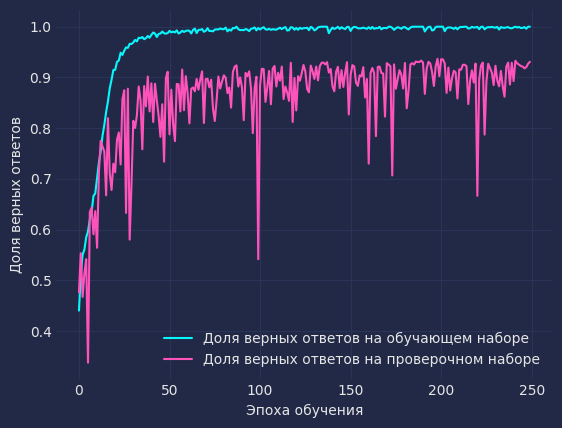

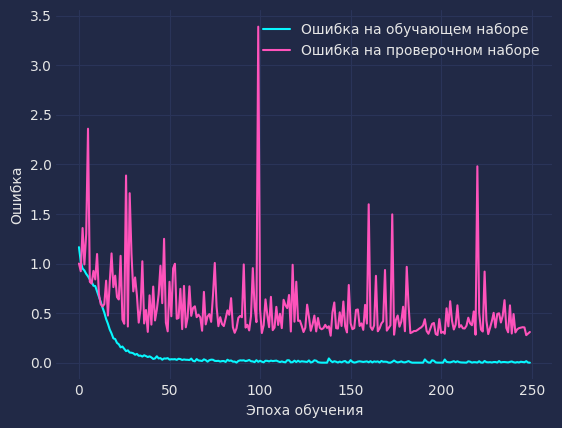

In [48]:
mt_model_utils.plot_training_history(HISTORY)

## Тестирование

### Отдельные изображения из Интернет

In [49]:
from PIL import Image

img = Image.open('./data/object-test/Mercedes/image_2160_LMercedes.jpg')
model.predict_proba_from_pil_image(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


{'Ferrari': 0.99283034, 'Mercedes': 0.0067078, 'Renault': 0.00046189746}

In [50]:
from PIL import Image

img = Image.open('./data-misc/ferrari-testarossa-convertible-exotic-car-series-monogram-2782-doos.jpg')
model.predict_proba_from_pil_image(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


{'Ferrari': 0.0036940372, 'Mercedes': 0.99453694, 'Renault': 0.0017689484}

### Тестовая выборка

In [51]:
FINAL_TEST_SET = TEST_DATASET.drop(columns=['id'])
FINAL_TEST_SET['file_path'] = FINAL_TEST_SET['file_path'].apply(lambda path: str(path))
FINAL_TEST_SET.head(5)

,file_path,label_original
2183,data/object-prepared/image_2183.jpg,Mercedes
520,data/object-prepared/image_520.jpg,Ferrari
2673,data/object-prepared/image_2673.jpg,Renault
32,data/object-prepared/image_32.jpg,Ferrari
719,data/object-prepared/image_719.jpg,Ferrari


In [52]:
model.score_from_dataframe(FINAL_TEST_SET, FINAL_TEST_SET['label_original'])

Found 343 validated image filenames.


/home/sorcerer/.pyenv/versions/3.11.9/envs/dl_python_3_11_9/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

I0000 00:00:1718724718.440873  314043 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_212', 468 bytes spill stores, 352 bytes spill loads

I0000 00:00:1718724718.515080  314026 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_212', 956 bytes spill stores, 624 bytes spill loads



11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step


88.62973760932945

In [53]:
MODEL_DIRECTORY = paths.Path('./model')
MODEL_DIRECTORY.mkdir(exist_ok=True)
mt_model_cv.CNNCustomClassifier.save(model, MODEL_DIRECTORY)

In [54]:
loaded_model = mt_model_cv.CNNCustomClassifier.load(MODEL_DIRECTORY)
loaded_model.score_from_dataframe(FINAL_TEST_SET, FINAL_TEST_SET['label_original'])

Found 343 validated image filenames.
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


88.62973760932945

In [55]:
mt_model_cv.CNNCustomClassifier.save_lightweight(model, MODEL_DIRECTORY)

In [56]:
loaded_model_lightweight = mt_model_cv.CNNCustomClassifier.load_lightweight(MODEL_DIRECTORY)
loaded_model_lightweight.score_from_dataframe(FINAL_TEST_SET, FINAL_TEST_SET['label_original'])

Found 343 validated image filenames.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


88.62973760932945